# Download Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-20 02:29:53--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.72, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2023-03-20 02:29:54 (52.7 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [3]:
%matplotlib inline

# Classes & Helper Functions

## Load Data Files

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS, EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 5 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [7]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, max_length):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs, max_length):
    return [pair for pair in pairs if filterPair(pair, max_length)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, max_length, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, max_length)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

## The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Attention Decoder

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

## Transformer

Note this is based on [this tutorial](https://pytorch.org/tutorials/beginner/translation_transformer.html).

In [12]:
# modified for transformer - DONE
from torch import Tensor
from torch.nn import Transformer

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 maxlen: int,
                 dropout: float = 0.0 # default: no dropout
                 ):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 maxlen: int,
                 num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6,
                 nhead: int = 8,
                 emb_size: int = 32,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout, maxlen=maxlen)
        self.softmax = nn.LogSoftmax(dim=1) # apply later in train, eval function

    # this class was originally written to make use of CrossEntropyLoss, will apply softmax later in train/eval
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None)
        outs = self.generator(outs)
        return outs 

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [13]:
# modified for transformer - DONE
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# no need for padding
# src_mask is just a an additive mask of 0s, so no effect to the model itself
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    return src_mask, tgt_mask

## Training
========

### Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




#### Seq2Seq

In [15]:
teacher_forcing_ratio = 0.5

# modified: introduced use_attention
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length, use_attention):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # modified: feed encoder_outputs if use_attention=True, else don't
            if use_attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # modified: feed encoder_outputs if use_attention=True, else don't
            if use_attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  
  
# modified: introduced use_attention
def eval(input_tensor, target_tensor, encoder, decoder, criterion, max_length, use_attention):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        # modified: feed encoder_outputs if use_attention=True, else don't
        if use_attention:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    return loss.item() / target_length

# modified: introduced max_length, input_lang, output_lang, use_attention
def eval_dataset(dataset, encoder, decoder, criterion, max_length, input_lang, output_lang, use_attention=True):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair, input_lang, output_lang)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval(input_tensor, target_tensor, encoder, decoder, criterion, use_attention=use_attention, max_length=max_length) # modified: add use_attention, max_length
    return loss / len(dataset)


The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [17]:
# modified: introduced train_data, validation_data, max_length, input_lang, output_lang, use_attention, saved_encoder_name, saved_decoder_name
def trainIters(encoder, decoder, n_iters, train_data, validation_data, max_length,
               input_lang, output_lang,
               print_every=2000, plot_every=1000,
               use_attention=True, saved_encoder_name='encoder_model', saved_decoder_name='decoder_model'
               ):
    start = time.time()
    all_train_losses = []
    all_validation_losses = []
    train_loss = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    decoder_optimizer = torch.optim.Adam(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # modified: add use_attention, max_length
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, 
                     use_attention=use_attention, max_length=max_length)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            # modified: add use_attention, max_length, input_lang, output_lang
            average_validation_loss = eval_dataset(validation_data, encoder, decoder, criterion, 
                                                   use_attention=use_attention, max_length=max_length,
                                                   input_lang=input_lang, output_lang=output_lang)

            # save model with best validation loss
            if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
                torch.save(encoder, '{}.pt'.format(saved_encoder_name))
                torch.save(decoder, '{}.pt'.format(saved_decoder_name))
            all_validation_losses.append(average_validation_loss)
            
    #showPlot(all_train_losses, all_validation_losses)
    return all_train_losses, all_validation_losses

#### Transformer

In [18]:
# modified for transformers - DONE
teacher_forcing_ratio_trans = 0.5

def train_trans(src, tgt, model, optimizer, criterion, max_length):

    optimizer.zero_grad()

    input_length = src.size(0)
    target_length = tgt.size(0)

    loss = 0

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio_trans else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # define tgt_input and tgt_out
        SOS_tensor = torch.tensor([[SOS_token]], device=device)
        tgt_with_SOS = torch.cat((SOS_tensor, tgt), dim=0) # add SOS token in front of target tensor
        tgt_input = tgt_with_SOS[:-1, :] # exclude EOS token at the end
        tgt_out = tgt_with_SOS[1:, :] # shift to the right by one

        # create masks
        # note src_mask is just an additive mask of 0s - no effect to the model
        src_mask, tgt_mask = create_mask(src, tgt_input) 

        logits = model(src, tgt_input, src_mask, tgt_mask=tgt_mask) # get the probabilities

        # compute and add the loss for each word
        for di in range(target_length):
            # apply model.softmax here (code was originally for CrossEntropyLoss)
            loss += criterion(model.softmax(logits[di]), tgt_out[di])

    else:
        # Without teacher forcing: use its own predictions as the next input
        src_mask = (torch.zeros(src.shape[0], src.shape[0])).type(torch.bool).to(device)
        memory = model.encode(src, src_mask) # the sequence from the last layer of the encoder
        ys = torch.ones(1, 1).fill_(SOS_token).type(torch.long).to(device) # the sequence to the decoder
        for di in range(target_length):
            memory = memory.to(device)
            tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
            
            out = model.decode(ys, memory, tgt_mask) # decode
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1]) # get probability over output_lang.n_words
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.squeeze().detach() # detach from history as input
            next_word = next_word.item() # get most likely word index

            # apply model.softmax here (code was originally for CrossEntropyLoss)
            loss += criterion(model.softmax(prob), tgt[di]) # compute and add the loss for each word

            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0) # update sequence to decoder
            if next_word == EOS_token: # check if we reached EOS
                break

    loss.backward()

    optimizer.step()

    # print(loss.item() / target_length)
    return loss.item() / target_length

In [19]:
# modified for transformers - DONE
def eval_trans(src, tgt, model, criterion, max_length):

    input_length = src.size(0)
    target_length = tgt.size(0)

    loss = 0

    # Without teacher forcing: use its own predictions as the next input
    src_mask = (torch.zeros(src.shape[0], src.shape[0])).type(torch.bool).to(device)
    memory = model.encode(src, src_mask) # the sequence from the last layer of the encoder
    ys = torch.ones(1, 1).fill_(SOS_token).type(torch.long).to(device) # the sequence to the decoder
    for di in range(target_length):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
            
        out = model.decode(ys, memory, tgt_mask) # decode
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1]) # get probability over output_lang.n_words
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.squeeze().detach() # detach from history as input
        next_word = next_word.item() # get most likely word index

        # apply model.softmax here (code was originally for CrossEntropyLoss)
        loss += criterion(model.softmax(prob), tgt[di]) # compute and add the loss for each word
        
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0) # update sequence to decoder
        if next_word == EOS_token: # check if we reached EOS
            break

    return loss.item() / target_length

# modified for transformers - DONE
def eval_dataset_trans(dataset, model, criterion, max_length, input_lang, output_lang):
    loss = 0
    for pair in dataset:
        pair_tensor = tensorsFromPair(pair, input_lang, output_lang)
        input_tensor = pair_tensor[0]
        target_tensor = pair_tensor[1]
        loss += eval_trans(input_tensor, target_tensor, model, criterion, max_length=max_length) # modified: add use_attention, max_length
    return loss / len(dataset)


In [20]:
# modified for transformers - DONE
def trainIters_trans(model, n_iters, train_data, validation_data, max_length,
               input_lang, output_lang,
               print_every=2000, plot_every=1000,
               saved_model_name='model1'
               ):
    start = time.time()
    all_train_losses = []
    all_validation_losses = []
    train_loss = 0  # Reset every plot_every

    optimizer = torch.optim.Adam(model.parameters())
    training_pairs = [tensorsFromPair(random.choice(train_data), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    print('\nIter \tTrain% \tTime \t\tTrain_loss')
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_trans(input_tensor, target_tensor, model, optimizer, criterion, max_length=max_length)
        train_loss += loss

        if iter % print_every == 0:
            print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

        if iter % plot_every == 0:
            all_train_losses.append(train_loss / plot_every)
            train_loss = 0
            
        # Compute loss based on validation data
        if iter % plot_every == 0:
            average_validation_loss = eval_dataset_trans(validation_data, model, criterion, 
                                                   max_length=max_length,
                                                   input_lang=input_lang, output_lang=output_lang)

            # save model with best validation loss
            if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
                torch.save(model, '{}.pt'.format(saved_model_name))
            all_validation_losses.append(average_validation_loss)
            
    return all_train_losses, all_validation_losses




### Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


# modified: rewrote showPlot to show multiple curves in each graph
def showPlot(all_train_losses_ls, all_validation_losses_ls, model_names, max_length):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    for all_train_losses_i in range(len(all_train_losses_ls)):
        plt.plot(all_train_losses_ls[all_train_losses_i])
    plt.title('Seq2seq translation (training loss) - MAX_LENGTH={}'.format(max_length))
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend([model_name for model_name in model_names], loc='upper right')

    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    for all_validation_losses_i in range(len(all_validation_losses_ls)):
        plt.plot(all_validation_losses_ls[all_validation_losses_i])
    plt.title('Seq2seq translation (validation loss) - MAX_LENGTH={}'.format(max_length))
    plt.ylabel('Negative Log Likelihood')
    plt.xlabel('# of 1000 iterations')
    plt.legend([model_name for model_name in model_names], loc='upper right')


## Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [17]:
def evaluate(encoder, decoder, sentence, max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

# Experiment 1 (MAX_LENGTH = 5)

## Preparing Data

In [22]:
MAX_LENGTH = 5
MAX_LENGTH_STRING = '_max_length_{}'.format(MAX_LENGTH)

input_lang_max5, output_lang_max5, pairs = prepareData('eng', 'fra', max_length=MAX_LENGTH, reverse=True)
random.shuffle(pairs)
train_data_max5 = pairs[0:int(math.floor(0.8*len(pairs)))]
validation_data_max5 = pairs[int(math.floor(0.8*len(pairs)))+1:int(math.floor(0.9*len(pairs)))]
test_data_max5 = pairs[int(math.floor(0.9*len(pairs)))+1:]

Reading lines...
Read 135842 sentence pairs
Trimmed to 1404 sentence pairs
Counting words...
Counted words:
fra 940
eng 466


## Model 1: Seq2Seq with Attention

In [23]:
hidden_size = 32
input_lang = input_lang_max5
output_lang = output_lang_max5

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, max_length=MAX_LENGTH).to(device)
saved_encoder_name1 = 'seq2seq_translation_encoder_model'
saved_decoder_name1 = 'seq2seq_translation_attn_decoder_model'

# default: use_attention=True
all_train_losses1_max5, all_validation_losses1_max5 = trainIters(encoder, attn_decoder, 30000,
                                                                 train_data_max5, validation_data_max5, max_length=MAX_LENGTH,
                                                                 input_lang=input_lang, output_lang=output_lang,
                                                                 saved_encoder_name=saved_encoder_name1 + MAX_LENGTH_STRING,
                                                                 saved_decoder_name=saved_decoder_name1 + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 29s) 	1.4302
4000 	13% 	(0m 56s) 	1.2226
6000 	20% 	(1m 23s) 	1.1186
8000 	26% 	(1m 49s) 	1.0707
10000 	33% 	(2m 15s) 	0.9969
12000 	40% 	(2m 42s) 	0.9308
14000 	46% 	(3m 10s) 	0.8910
16000 	53% 	(3m 40s) 	0.8168
18000 	60% 	(4m 11s) 	0.7497
20000 	66% 	(4m 44s) 	0.6943
22000 	73% 	(5m 16s) 	0.6410
24000 	80% 	(5m 47s) 	0.5714
26000 	86% 	(6m 16s) 	0.5585
28000 	93% 	(6m 45s) 	0.4913
30000 	100% 	(7m 12s) 	0.4705


## Model 2: Seq2Seq without Attention

In [24]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
saved_encoder_name2 = 'seq2seq_translation_encoder_model_no_attention'
saved_decoder_name2 = 'seq2seq_translation_decoder_model_no_attention'

# set use_attention to False, set saved_encoder_name and saved_decoder_name
all_train_losses2_max5, all_validation_losses2_max5 = trainIters(encoder, decoder, 30000, 
                                                                 train_data_max5, validation_data_max5, max_length=MAX_LENGTH,
                                                                 input_lang=input_lang, output_lang=output_lang,
                                                                 use_attention = False, 
                                                                 saved_encoder_name = saved_encoder_name2 + MAX_LENGTH_STRING,
                                                                 saved_decoder_name = saved_decoder_name2 + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 18s) 	1.4198
4000 	13% 	(0m 36s) 	1.2148
6000 	20% 	(0m 55s) 	1.1355
8000 	26% 	(1m 13s) 	1.1020
10000 	33% 	(1m 33s) 	1.0455
12000 	40% 	(1m 51s) 	0.9972
14000 	46% 	(2m 13s) 	0.9464
16000 	53% 	(2m 34s) 	0.8989
18000 	60% 	(2m 52s) 	0.8477
20000 	66% 	(3m 12s) 	0.7910
22000 	73% 	(3m 32s) 	0.7538
24000 	80% 	(3m 50s) 	0.7149
26000 	86% 	(4m 13s) 	0.6844
28000 	93% 	(4m 30s) 	0.6415
30000 	100% 	(4m 48s) 	0.5850


## Model 3: Transformer

In [25]:
SRC_VOCAB_SIZE = input_lang.n_words
TGT_VOCAB_SIZE = output_lang.n_words
NHEAD = 8
FFN_HID_DIM = 32
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
hidden_size = 32

transformer = Seq2SeqTransformer(src_vocab_size = input_lang.n_words, tgt_vocab_size = output_lang.n_words,
                                 maxlen = MAX_LENGTH, 
                                 num_encoder_layers = NUM_ENCODER_LAYERS, num_decoder_layers = NUM_DECODER_LAYERS,
                                 nhead=NHEAD, emb_size = hidden_size, dim_feedforward = FFN_HID_DIM).to(device)

# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

saved_transformer_name = 'transformer_model'

# set use_attention to False, set saved_encoder_name and saved_decoder_name
all_train_losses3_max5, all_validation_losses3_max5 = trainIters_trans(transformer, 30000, 
                                                                       train_data_max5, validation_data_max5, max_length=MAX_LENGTH,
                                                                       input_lang=input_lang, output_lang=output_lang,
                                                                       saved_model_name = saved_transformer_name + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 36s) 	1.5463
4000 	13% 	(1m 21s) 	1.2726
6000 	20% 	(2m 4s) 	1.2065
8000 	26% 	(2m 52s) 	1.1596
10000 	33% 	(3m 39s) 	1.0901
12000 	40% 	(4m 17s) 	1.0464
14000 	46% 	(4m 57s) 	1.0139
16000 	53% 	(5m 42s) 	0.9096
18000 	60% 	(6m 26s) 	0.8405
20000 	66% 	(7m 10s) 	0.7300
22000 	73% 	(7m 49s) 	0.6553
24000 	80% 	(8m 29s) 	0.6520
26000 	86% 	(9m 8s) 	0.5324
28000 	93% 	(9m 46s) 	0.5132
30000 	100% 	(10m 26s) 	0.4455


# Experiment 2 (MAX_LENGTH = 10)

## Preparing Data

In [26]:
MAX_LENGTH = 10
MAX_LENGTH_STRING = '_max_length_{}'.format(MAX_LENGTH)

input_lang_max10, output_lang_max10, pairs = prepareData('eng', 'fra', max_length=MAX_LENGTH, reverse=True)
random.shuffle(pairs)
train_data_max10 = pairs[0:int(math.floor(0.8*len(pairs)))]
validation_data_max10 = pairs[int(math.floor(0.8*len(pairs)))+1:int(math.floor(0.9*len(pairs)))]
test_data_max10 = pairs[int(math.floor(0.9*len(pairs)))+1:]

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


## Model 1: Seq2Seq with Attention

In [27]:
hidden_size = 32
input_lang = input_lang_max10
output_lang = output_lang_max10

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, max_length=MAX_LENGTH).to(device)

all_train_losses1_max10, all_validation_losses1_max10 = trainIters(encoder, attn_decoder, 30000,
                                                                   train_data_max10, validation_data_max10, max_length=MAX_LENGTH,
                                                                   input_lang=input_lang, output_lang=output_lang,
                                                                   saved_encoder_name=saved_encoder_name1 + MAX_LENGTH_STRING,
                                                                   saved_decoder_name=saved_decoder_name1 + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 42s) 	3.0132
4000 	13% 	(1m 31s) 	2.7896
6000 	20% 	(2m 19s) 	2.6340
8000 	26% 	(3m 10s) 	2.6156
10000 	33% 	(4m 0s) 	2.5068
12000 	40% 	(4m 47s) 	2.4163
14000 	46% 	(5m 38s) 	2.3973
16000 	53% 	(6m 30s) 	2.3214
18000 	60% 	(7m 22s) 	2.2719
20000 	66% 	(8m 14s) 	2.2192
22000 	73% 	(9m 7s) 	2.2100
24000 	80% 	(9m 58s) 	2.1721
26000 	86% 	(10m 46s) 	2.1729
28000 	93% 	(11m 32s) 	2.1138
30000 	100% 	(12m 19s) 	2.1242


## Model 2: Seq2Seq without Attention

In [28]:
hidden_size = 32
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

all_train_losses2_max10, all_validation_losses2_max10 = trainIters(encoder, decoder, 30000, 
                                                                   train_data_max10, validation_data_max10, max_length=MAX_LENGTH,
                                                                   input_lang=input_lang, output_lang=output_lang,
                                                                   use_attention = False, 
                                                                   saved_encoder_name = saved_encoder_name2 + MAX_LENGTH_STRING,
                                                                   saved_decoder_name = saved_decoder_name2 + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 26s) 	3.1364
4000 	13% 	(0m 55s) 	2.8627
6000 	20% 	(1m 25s) 	2.6507
8000 	26% 	(1m 56s) 	2.7466
10000 	33% 	(2m 28s) 	2.6498
12000 	40% 	(3m 3s) 	2.6086
14000 	46% 	(3m 36s) 	2.5957
16000 	53% 	(4m 9s) 	2.5364
18000 	60% 	(4m 41s) 	2.5068
20000 	66% 	(5m 15s) 	2.4480
22000 	73% 	(5m 47s) 	2.4924
24000 	80% 	(6m 25s) 	2.3732
26000 	86% 	(6m 58s) 	2.3732
28000 	93% 	(7m 32s) 	2.3475
30000 	100% 	(8m 5s) 	2.2887


## Model 3: Transformer

In [29]:
SRC_VOCAB_SIZE = input_lang.n_words
TGT_VOCAB_SIZE = output_lang.n_words
NHEAD = 8
FFN_HID_DIM = 32
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
hidden_size = 32

transformer = Seq2SeqTransformer(src_vocab_size = input_lang.n_words, tgt_vocab_size = output_lang.n_words,
                                 maxlen = MAX_LENGTH, 
                                 num_encoder_layers = NUM_ENCODER_LAYERS, num_decoder_layers = NUM_DECODER_LAYERS,
                                 nhead=NHEAD, emb_size = hidden_size, dim_feedforward = FFN_HID_DIM).to(device)

# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

saved_transformer_name = 'transformer_model'

# set use_attention to False, set saved_encoder_name and saved_decoder_name
all_train_losses3_max10, all_validation_losses3_max10 = trainIters_trans(transformer, 30000, 
                                                                       train_data_max10, validation_data_max10, max_length=MAX_LENGTH,
                                                                       input_lang=input_lang, output_lang=output_lang,
                                                                       saved_model_name = saved_transformer_name + MAX_LENGTH_STRING)


Iter 	Train% 	Time 		Train_loss
2000 	6% 	(0m 51s) 	3.1689
4000 	13% 	(1m 57s) 	2.8560
6000 	20% 	(3m 4s) 	2.7502
8000 	26% 	(4m 13s) 	2.7027
10000 	33% 	(5m 29s) 	2.7023
12000 	40% 	(6m 53s) 	2.6204
14000 	46% 	(8m 19s) 	2.5640
16000 	53% 	(9m 32s) 	2.5261
18000 	60% 	(10m 49s) 	2.4970
20000 	66% 	(12m 2s) 	2.4548
22000 	73% 	(13m 14s) 	2.4828
24000 	80% 	(14m 23s) 	2.4733
26000 	86% 	(15m 31s) 	2.4682
28000 	93% 	(16m 37s) 	2.3959
30000 	100% 	(17m 45s) 	2.3873


# Results

## Training Loss & Validation Loss Graphs, Test Loss

Average test loss (MAX_LENGTH = 5): 
  Seq2Seq with Attention: 1.3457122656277252
  Seq2Seq without Attention: 1.3406227823666164
  Transformer: 1.4452030794961113

Average test loss (MAX_LENGTH = 10): 
  Seq2Seq with Attention: 2.5974150742323707
  Seq2Seq without Attention: 2.6884749752395107
  Transformer: 2.5481647825418947


<Figure size 432x288 with 0 Axes>

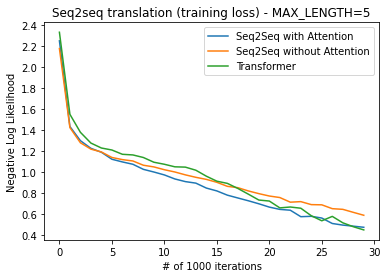

<Figure size 432x288 with 0 Axes>

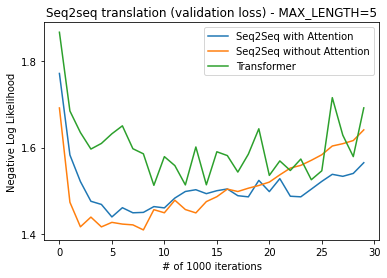

<Figure size 432x288 with 0 Axes>

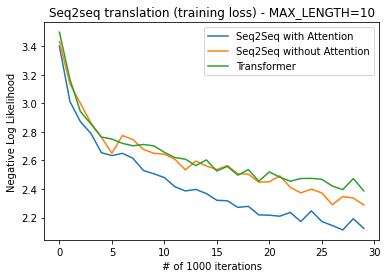

<Figure size 432x288 with 0 Axes>

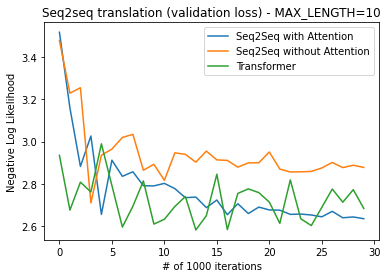

In [30]:
model_names = ["Seq2Seq with Attention", "Seq2Seq without Attention", "Transformer"]

############### Training Loss & Validation Loss Graphs ###############
## MAX_LENGTH = 5
all_train_losses_ls_max5 = [all_train_losses1_max5, all_train_losses2_max5, all_train_losses3_max5]
all_validation_losses_ls_max5 = [all_validation_losses1_max5, all_validation_losses2_max5, all_validation_losses3_max5]
showPlot(all_train_losses_ls_max5, all_validation_losses_ls_max5, model_names, max_length=5)

## MAX_LENGTH = 10
all_train_losses_ls_max10 = [all_train_losses1_max10, all_train_losses2_max10, all_train_losses3_max10]
all_validation_losses_ls_max10 = [all_validation_losses1_max10, all_validation_losses2_max10, all_validation_losses3_max10]
showPlot(all_train_losses_ls_max10, all_validation_losses_ls_max10, model_names, max_length=10)

############### evaluate on test set and print average test loss ###############
## MAX_LENGTH = 5
MAX_LENGTH=5
MAX_LENGTH_STRING = '_max_length_{}'.format(MAX_LENGTH)
input_lang = input_lang_max5
output_lang = output_lang_max5

print("Average test loss (MAX_LENGTH = 5): ")

# Model 1: Seq2Seq with Attention
encoder = torch.load('{}.pt'.format(saved_encoder_name1 + MAX_LENGTH_STRING))
decoder = torch.load('{}.pt'.format(saved_decoder_name1 + MAX_LENGTH_STRING))
average_test_loss = eval_dataset(test_data_max5, encoder, decoder, nn.NLLLoss(), 
                                 input_lang=input_lang, output_lang=output_lang,
                                 max_length=MAX_LENGTH)
print(('  {}: ' + str(average_test_loss)).format(model_names[0]))

# Model 2: Seq2Seq without Attention
encoder = torch.load('{}.pt'.format(saved_encoder_name2 + MAX_LENGTH_STRING))
decoder = torch.load('{}.pt'.format(saved_decoder_name2 + MAX_LENGTH_STRING))
average_test_loss = eval_dataset(test_data_max5, encoder, decoder, nn.NLLLoss(),  
                                 input_lang=input_lang, output_lang=output_lang,
                                 max_length=MAX_LENGTH, use_attention=False) # no attention used
print(('  {}: ' + str(average_test_loss)).format(model_names[1]))

# Model 3: Transformer
transformer = torch.load('{}.pt'.format(saved_transformer_name + MAX_LENGTH_STRING))
average_test_loss = eval_dataset_trans(test_data_max5, transformer, nn.NLLLoss(),  
                                      input_lang=input_lang, output_lang=output_lang,
                                      max_length=MAX_LENGTH)
print(('  {}: ' + str(average_test_loss)).format(model_names[2]))

## MAX_LENGTH = 10
MAX_LENGTH=10
MAX_LENGTH_STRING = '_max_length_{}'.format(MAX_LENGTH)
input_lang = input_lang_max10
output_lang = output_lang_max10

print("\nAverage test loss (MAX_LENGTH = 10): ")

# Model 1: Seq2Seq with Attention
encoder = torch.load('{}.pt'.format(saved_encoder_name1 + MAX_LENGTH_STRING))
decoder = torch.load('{}.pt'.format(saved_decoder_name1 + MAX_LENGTH_STRING))
average_test_loss = eval_dataset(test_data_max10, encoder, decoder, nn.NLLLoss(), 
                                 input_lang=input_lang, output_lang=output_lang,
                                 max_length=MAX_LENGTH)
print(('  {}: ' + str(average_test_loss)).format(model_names[0]))

# Model 2: Seq2Seq without Attention
encoder = torch.load('{}.pt'.format(saved_encoder_name2 + MAX_LENGTH_STRING))
decoder = torch.load('{}.pt'.format(saved_decoder_name2 + MAX_LENGTH_STRING))
average_test_loss = eval_dataset(test_data_max10, encoder, decoder, nn.NLLLoss(),  
                                 input_lang=input_lang, output_lang=output_lang,
                                 max_length=MAX_LENGTH, use_attention=False) # no attention used
print(('  {}: ' + str(average_test_loss)).format(model_names[1]))

# Model 3: Transformer
transformer = torch.load('{}.pt'.format(saved_transformer_name + MAX_LENGTH_STRING))
average_test_loss = eval_dataset_trans(test_data_max10, transformer, nn.NLLLoss(),  
                                       input_lang=input_lang, output_lang=output_lang,
                                       max_length=MAX_LENGTH) 
print(('  {}: ' + str(average_test_loss)).format(model_names[2]))


## Explanation

Based on the average test loss, we see that:
- MAX_LENGTH = 5: The Seq2Seq without attention model performed the best, followed by the Seq2Seq with attention and the transformer. Note that the performance of the Seq2Seq without attention is similar (only slightly better) compared to the one with attention, since the benefit of using attention for shorter sentences is less obvious.
- MAX_LENGTH = 10: The transformer performed the best, followed by Seq2Seq with attention and Seq2Seq without attention.

From smallest to largest, we also see:

*MAX_LENGTH = 5:*
- Lowest training loss (out of all epochs): Transformer < Seq2Seq with attention < Seq2Seq without attention.
- Lowest validation loss (out of all epochs): Seq2Seq without attention < Seq2Seq with attention < Transformer.
  - Looking at how the validation loss is increasing with the number of epoch, this seems to suggest overfitting in all 3 models.

*MAX_LENGTH = 10:*
- Lowest training loss (out of all epochs): Seq2Seq with attention < Seq2Seq without attention < Transformer.
- Lowest validation loss (out of all epochs): Transformer < Seq2Seq with attention < Seq2Seq without attention.

**Architecture: RNN vs Transformer**

There are several challenges that come with the RNN architecture:
- Gradient vanishing and explosion: if the gradient is a product of factors less than (or more than) 1, the gradient gets increasingly smaller (or larger) as the product gets longer, leading to gradient vanishing (or explosion).
- Long range dependencies: loss of information when taking in very long input sequences (due to the forgetting property).
- Recurrence prevents parallel computation: need to compute sequentially.
- Requires more training steps: it takes longer to optimize as the recurrent structure leads to many interdependencies.

The transformer architecture mitigates the challenges outlined above:
- No gradient vanishing and explosion: the transformer network tends to be shallower, and the use of layer normalization prevents any numerical value from blowing up or vanishing to 0. 
- Facilitate long range dependencies due to a shallower network (compared to RNNs).
- Facilitates parallel computation: there is no recurrence between time steps, causing computation to be independent of sequence length.
- Fewer training steps: leads to better scalability.

In theory, the transformer generally performs better when compared to the Seq2Seq models (which is based on the RNN architecture), and even more so with longer input sequences (i.e. MAX_LENGTH=10 vs MAX_LENGTH = 5). In our case, it aligns with the theory when MAX_LENGTH = 10, but not for MAX_LENGTH = 5. Perhaps tweaking with the transformer parameters will lead to a better performance for shorter sentences.

**Attention:**

Attention is a mechanism that tries to align each output word with relevant input words by computing a softmax of the inputs. The use of attention is especially important when taking in very long input sequences, as it allows the network to "refer" back to the input sequence and focus on relevant words at each time step. This helps to somewhat mitigate the forgetting property in RNNs. As such, the Seq2Seq with attention has a better performance than the the Seq2Seq without attention, even more so with longer input sequences (i.e. MAX_LENGTH=10 vs MAX_LENGTH = 5). Note that in our case, both models have similar performances with MAX_LENGTH = 5.






